# Рекомендация тарифов

На основании данных подготовленных в проекте "Определение выгодного тарифа для телеком компании" подобрать и обучить модель, для прогнозирования предпочтений пользователей при выборе тарифов.

## 1. Откройте и изучите файл

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

df = pd.read_csv('/datasets/users_behavior.csv')

In [2]:
random_state = 4444 # Назначение переменной

In [3]:
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


### Вывод:

Ознакомились с данными: колонки приведены к нужным типам, пропусков нет.

## 2. Рзобьем данные на выборки

In [6]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']


features, features_test, target, target_test = train_test_split(
    features, target, test_size=0.2, random_state=random_state, stratify=target)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, train_size=0.6, random_state=random_state, stratify=target)

* train - 60%
* valid - 20%
* test - 20%

## 3. Исследуем модели

In [7]:
name = []
results = []

In [8]:
from sklearn.svm import LinearSVC

model = LinearSVC(random_state=random_state)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
result = model.score(features_valid, target_valid)

name.append('LinearSVC')
results.append(result)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=random_state)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
result = model.score(features_valid, target_valid)

name.append('LogisticRegression')
results.append(result)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
from sklearn.neighbors import KNeighborsClassifier
best_neighbors = 0
best_model = None
best_result = 0
for neighbors in range(1,15):
    model = KNeighborsClassifier(n_neighbors=neighbors)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_neighbors = neighbors
        best_model = model
        best_result = result
print(f'соседи: {best_neighbors}, результат: {best_result}')

name.append('KNeighborsClassifier')
results.append(best_result)

соседи: 13, результат: 0.771622934888241


In [11]:
from sklearn.tree import DecisionTreeClassifier

best_depth = 0
best_model = None
best_result = 0
for depth in range(1,15):
    model = DecisionTreeClassifier(random_state=random_state, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_depth = depth
        best_model = model
        best_result = result
print(f'глубина: {best_depth}, результат: {best_result}')

name.append('DecisionTreeClassifier')
results.append(best_result)

глубина: 3, результат: 0.8104956268221575


In [12]:
from sklearn.ensemble import RandomForestClassifier

best_features = 0
best_criterion = None
best_depth = 0
best_model = None
best_result = 0
best_est = 0
from time import sleep

for crit in tqdm(['gini', 'entropy']):
    for max_features in ['sqrt', 'log2']:
        for est in range(30,35):
            for depth in range(5,15):
                model = RandomForestClassifier(random_state=random_state, criterion=crit,
                                    max_features=max_features, max_depth=depth, n_estimators=est)
                model.fit(features_train, target_train)
                predictions = model.predict(features_valid)
                result = model.score(features_valid, target_valid)
                if result > best_result:
                    best_criterion = crit
                    best_features = max_features
                    best_depth = depth
                    best_model = model
                    best_result = result
                    best_est = est
print(f'критерий: {best_criterion}, фичи: {best_features},\
количество деревьев: {best_est}, глубина: {best_depth}, результат: {best_result}')

name.append('RandomForestClassifier')
results.append(best_result)

100%|██████████| 2/2 [00:28<00:00, 14.25s/it]

критерий: entropy, фичи: sqrt,количество деревьев: 33, глубина: 11, результат: 0.8279883381924198


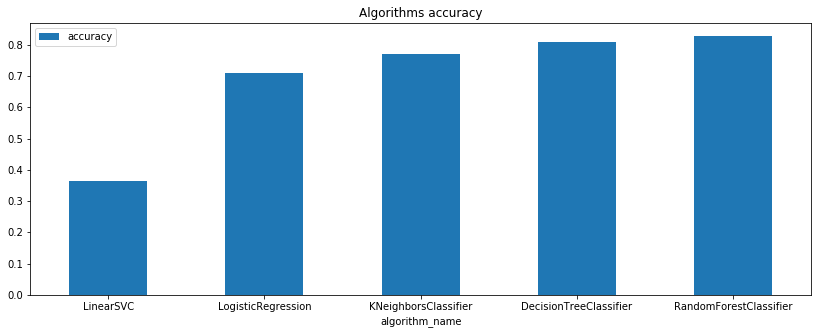

In [13]:


pivot = pd.DataFrame({"algorithm_name":name, "accuracy":results}).plot(kind='bar',
                        x= 'algorithm_name', figsize=(14,5), title='Algorithms accuracy')
plt.xticks(rotation=0)
pivot

### Вывод:

Хуже всего себя показали линейные модели, на втором месте сортировка по соседям, а победили деревья. В продакшн мы можем брать как одно дерево с параметрами глубины 7, мы потеряем немного в качестве предсказания, но значительно уменьшим нагрузку на сервера. Так и рандомный лес с параметрами: количество деревьев 33 и глубина 10. У дерева точность 81.04%, а у рандомного леса 82.79%.

*Grid Search предлагает нам параметры рандомного леса: количество деревьев 34, глубина 11. Возможно эти параметры будут давать более стабильный результат

## 4. Проверьте модель на тестовой выборке

Возьмем модель RandomForestClassifier с параметрами: критерий 'entropy', количество деревьев 33, глубина 11.

In [16]:
model = RandomForestClassifier(random_state=random_state, criterion='entropy',
                               max_depth=11, n_estimators=33)
model.fit(features, target)
predictions = model.predict(features_test)
result = model.score(features_test, target_test)
result

0.8102643856920684

## 5.Проверьте модели на адекватность

In [17]:
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [1]:
only_ultra = [0] * features_test.shape[0]

NameError: name 'features_test' is not defined

In [19]:
accuracy_score(target_test, only_ultra)

0.6936236391912908

Так как в нашей выборке тех кто пользуется тарифом "Ультра" значительно больше, то если мы всем будем предлагать тариф "Ультра" в 69% мы будем угадывать. Но, во-первых, в генеральной совокупности предпочтения могут отличаться, во вторых соотношение может измениться со временем.

In [20]:
import random
random_answer = [random.choice([0, 1]) for i in range(len(features_test))]

In [21]:
accuracy_score(target_test, random_answer)

0.49922239502332816

При рандомном распределение шанс угадать значительно ниже чем предсказания нашей модели.

### Вывод:

Применение алгоритмов оправдано.

### Общий вывод:



Сравнили несколько алгоритмов, подобрали оптимальные гиперпараметры. 

Наша модель может с 81% вероятностью подобрать подходящий тарифный план.

Рекомендации: 

    Если предлагать клиентам тп"Ультра" мы будем угадывать в 69% случаев. Но в таком случае мы потеряем   потенциальную прибыль от клиентов готовых подключить более дорогой тариф.
    
    При предоставлении большего числа данных по клиентам, к примеру: траты на связь в месяц, текущий     тариф. Модель скорей всего получится улучшить.
